# 5. Missingness Report by Racial and Ethnic Groups

Visualization of data completeness in the Therlid dataset stratified by ethnicity.


In [ ]:
# replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [ ]:
# install necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
import missingno as msno
import pandas_gbq
import re

import numpy as np
import warnings
warnings.filterwarnings("ignore")

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


In [ ]:
# load data temperature data stored in google collab or your created version using pd.read_csv()
%%bigquery final_df --project spring-carving-271217

SELECT *
FROM `spring-carving-271217.test.merged_temp_pairs`

Query is running:   0%|          |

Downloading:   0%|          |

## Functions and Defines

In [ ]:
def rename_columns(dataframe, column_names_old, column_names_new):
    column_mapping = dict(zip(column_names_old, column_names_new))
    dataframe.rename(columns=column_mapping, inplace=True)

def plot_missingness(final_df, group="Overall", figsize=(10, 6)):
    # Retain only columns that do not start with 'delta_'
    mdf = final_df[[column for column in final_df.columns if not column.startswith('delta_')]]

    # Retain only columns of interest
    mdf = mdf[columns_retained]

    # Call the function to rename the columns
    rename_columns(mdf, column_names_old, column_names_new)

    # Set the figure size
    plt.figure(figsize=figsize)

    # Sort the DataFrame by missingness and plot the Missingness Bar Chart
    mdf_sorted = msno.nullity_sort(mdf, sort='descending')  # or sort='ascending'
    bar = msno.bar(mdf_sorted, filter='top', sort='descending', fontsize=18, label_rotation=45)

    # Modify y-axis labels to percentages
    plt.yticks(np.arange(0, 1.1, 0.1), [str(int(x * 100)) + '%' for x in np.arange(0, 1.1, 0.1)])

    # Set the title of the plot
    plt.title(f"Covariates' Completeness\n {group} (N = {format(len(final_df), ',')})\n", fontsize=30)

    # Show the plot
    plt.show()

# columns to rename
column_names_old = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'height_admission',
    'BMI_admission', 'datetime_hospital_admit', 'datetime_hospital_discharge', 'datetime_icu_admit',
    'datetime_icu_discharge', 'los_hospital', 'los_ICU', 'comorbidity_score_name', 'comorbidity_score_value',
    'in_hospital_mortality', 'race_ethnicity', 'datetime_charted_temporal', 'abg_pH', 'abg_pCO2', 'abg_paO2', 'abg_SaO2',
    'abg_Carboxyhemoglobin', 'abg_Methemoglobin', 'datetime_charted_reference', 'vitals_heart_rate', 'vitals_resp_rate',
    'vitals_mbp_ni', 'vitals_sbp_ni', 'vitals_dbp_ni', 'vitals_mbp_i', 'vitals_sbp_i', 'vitals_dbp_i',
    'vitals_tspo2', 'cbc_hemoglobin', 'cbc_hematocrit', 'cbc_mch', 'cbc_mchc', 'cbc_mcv', 'cbc_platelet',
    'cbc_rbc', 'cbc_rdw', 'cbc_wbc', 'coag_fibrinogen', 'coag_inr', 'coag_pt', 'coag_ptt', 'bmp_sodium',
    'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine', 'bmp_glucose',
    'bmp_aniongap', 'bmp_calcium', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total',
    'hfp_bilirubin_direct', 'hfp_albumin', 'others_ck_cpk', 'others_ck_mb', 'others_ld_ldh',
    'sofa_past_overall_24hr', 'sofa_past_coagulation_24hr',
    'sofa_past_liver_24hr', 'sofa_past_cardiovascular_24hr', 'sofa_past_cns_24hr', 'sofa_past_renal_24hr',
    'sofa_future_overall_24hr', 'sofa_future_coagulation_24hr', 'sofa_future_liver_24hr',
    'sofa_future_cardiovascular_24hr', 'sofa_future_cns_24hr', 'sofa_future_renal_24hr',
    'vitals_tempc_0_2h_before', 'vitals_tempc_36h_48h_before', 'sofa_day1'
]

# column mappings
column_names_new = [
    'Subject ID', 'Hospital Admission ID', 'ICU Stay ID', 'Source Database', 'Hospital ID', 'Number of Beds Category',
    'Teaching Status', 'US Census Region', 'Admission Age', 'Female Sex', 'Admission Weight', 'Admission Height',
    'Admission BMI', 'Datetime of Hospital Admission', 'Datetime of Hospital Discharge', 'Datetime of ICU Admission',
    'Datetime of ICU Discharge', 'LOS Hospital', 'LOS ICU', 'Comorbidity Score Name', 'Comorbidity Score (Charlson/Elixhauser)',
    'In-Hospital Mortality', 'Race-Ethnicity', 'Temporal Timestamp', 'ABG pH', 'ABG pCO2', 'ABG paO2', 'ABG SaO2',
    'Carboxyhemoglobin', 'Methemoglobin', 'Reference Timestamp', 'Vitals Heart Rate', 'Vitals Resp Rate',
    'Vitals niMBP', 'Vitals niSBP', 'Vitals niDBP', 'Vitals iMBP', 'Vitals iSBP', 'Vitals iDBP',
    'Vitals SpO2', 'CBC Hemoglobin', 'CBC Hematocrit', 'CBC MCH', 'CBC MCHC', 'CBC MCV', 'CBC Platelets',
    'CBC RBC', 'CBC RDW', 'CBC WBC', 'Coagulation Fibrinogen', 'Coagulation INR', 'Coagulation PT', 'Coagulation PTT', 'Sodium',
    'Potassium', 'Chloride', 'Bicarbonate', 'Blood Urea Nitrogen', 'Creatinine', 'Glucose',
    'Anion-gap', 'Calcium', 'Lactate', 'Alanine Transaminase', 'Alkaline Phosphatase', 'Aspartate Transaminase', 'Bilirubin Total',
    'Bilirubin Direct', 'Albumin', 'Creatine Kinase', 'Creatine Kinase MB', 'Lactate Dehydrogenase',
    'SOFA Past Overall 24hr', 'SOFA Past Coagulation 24hr',
    'SOFA Past Liver 24hr', 'SOFA Past Cardiovascular 24hr', 'SOFA Past CNS 24hr', 'SOFA Past Renal 24hr',
    'SOFA Future Overall 24hr', 'SOFA Future Coagulation 24hr', 'SOFA Future Liver 24hr',
    'SOFA Future Cardiovascular 24hr', 'SOFA Future CNS 24hr', 'SOFA Future Renal 24hr',
    'Tempertature First Past Window', 'Tempertature Last Past Window', 'SOFA Day 1'
]

# define columns of interest
columns_retained = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'datetime_hospital_admit',
    'datetime_hospital_discharge', 'datetime_icu_admit', 'datetime_icu_discharge', 'los_hospital', 'los_ICU',
    'comorbidity_score_name', 'comorbidity_score_value', 'in_hospital_mortality', 'race_ethnicity', 'datetime_charted_temporal',
    'abg_Carboxyhemoglobin', 'abg_Methemoglobin', 'datetime_charted_reference', 'cbc_hemoglobin', 'coag_fibrinogen', 'coag_inr', 'coag_pt',
    'coag_ptt', 'bmp_sodium', 'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine',
    'bmp_glucose', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total', 'hfp_albumin',
    'others_ck_cpk', 'sofa_past_overall_24hr', 'sofa_future_overall_24hr',
    'vitals_tempc_0_2h_before', 'vitals_tempc_36h_48h_before', 'sofa_day1'
]

## Overall

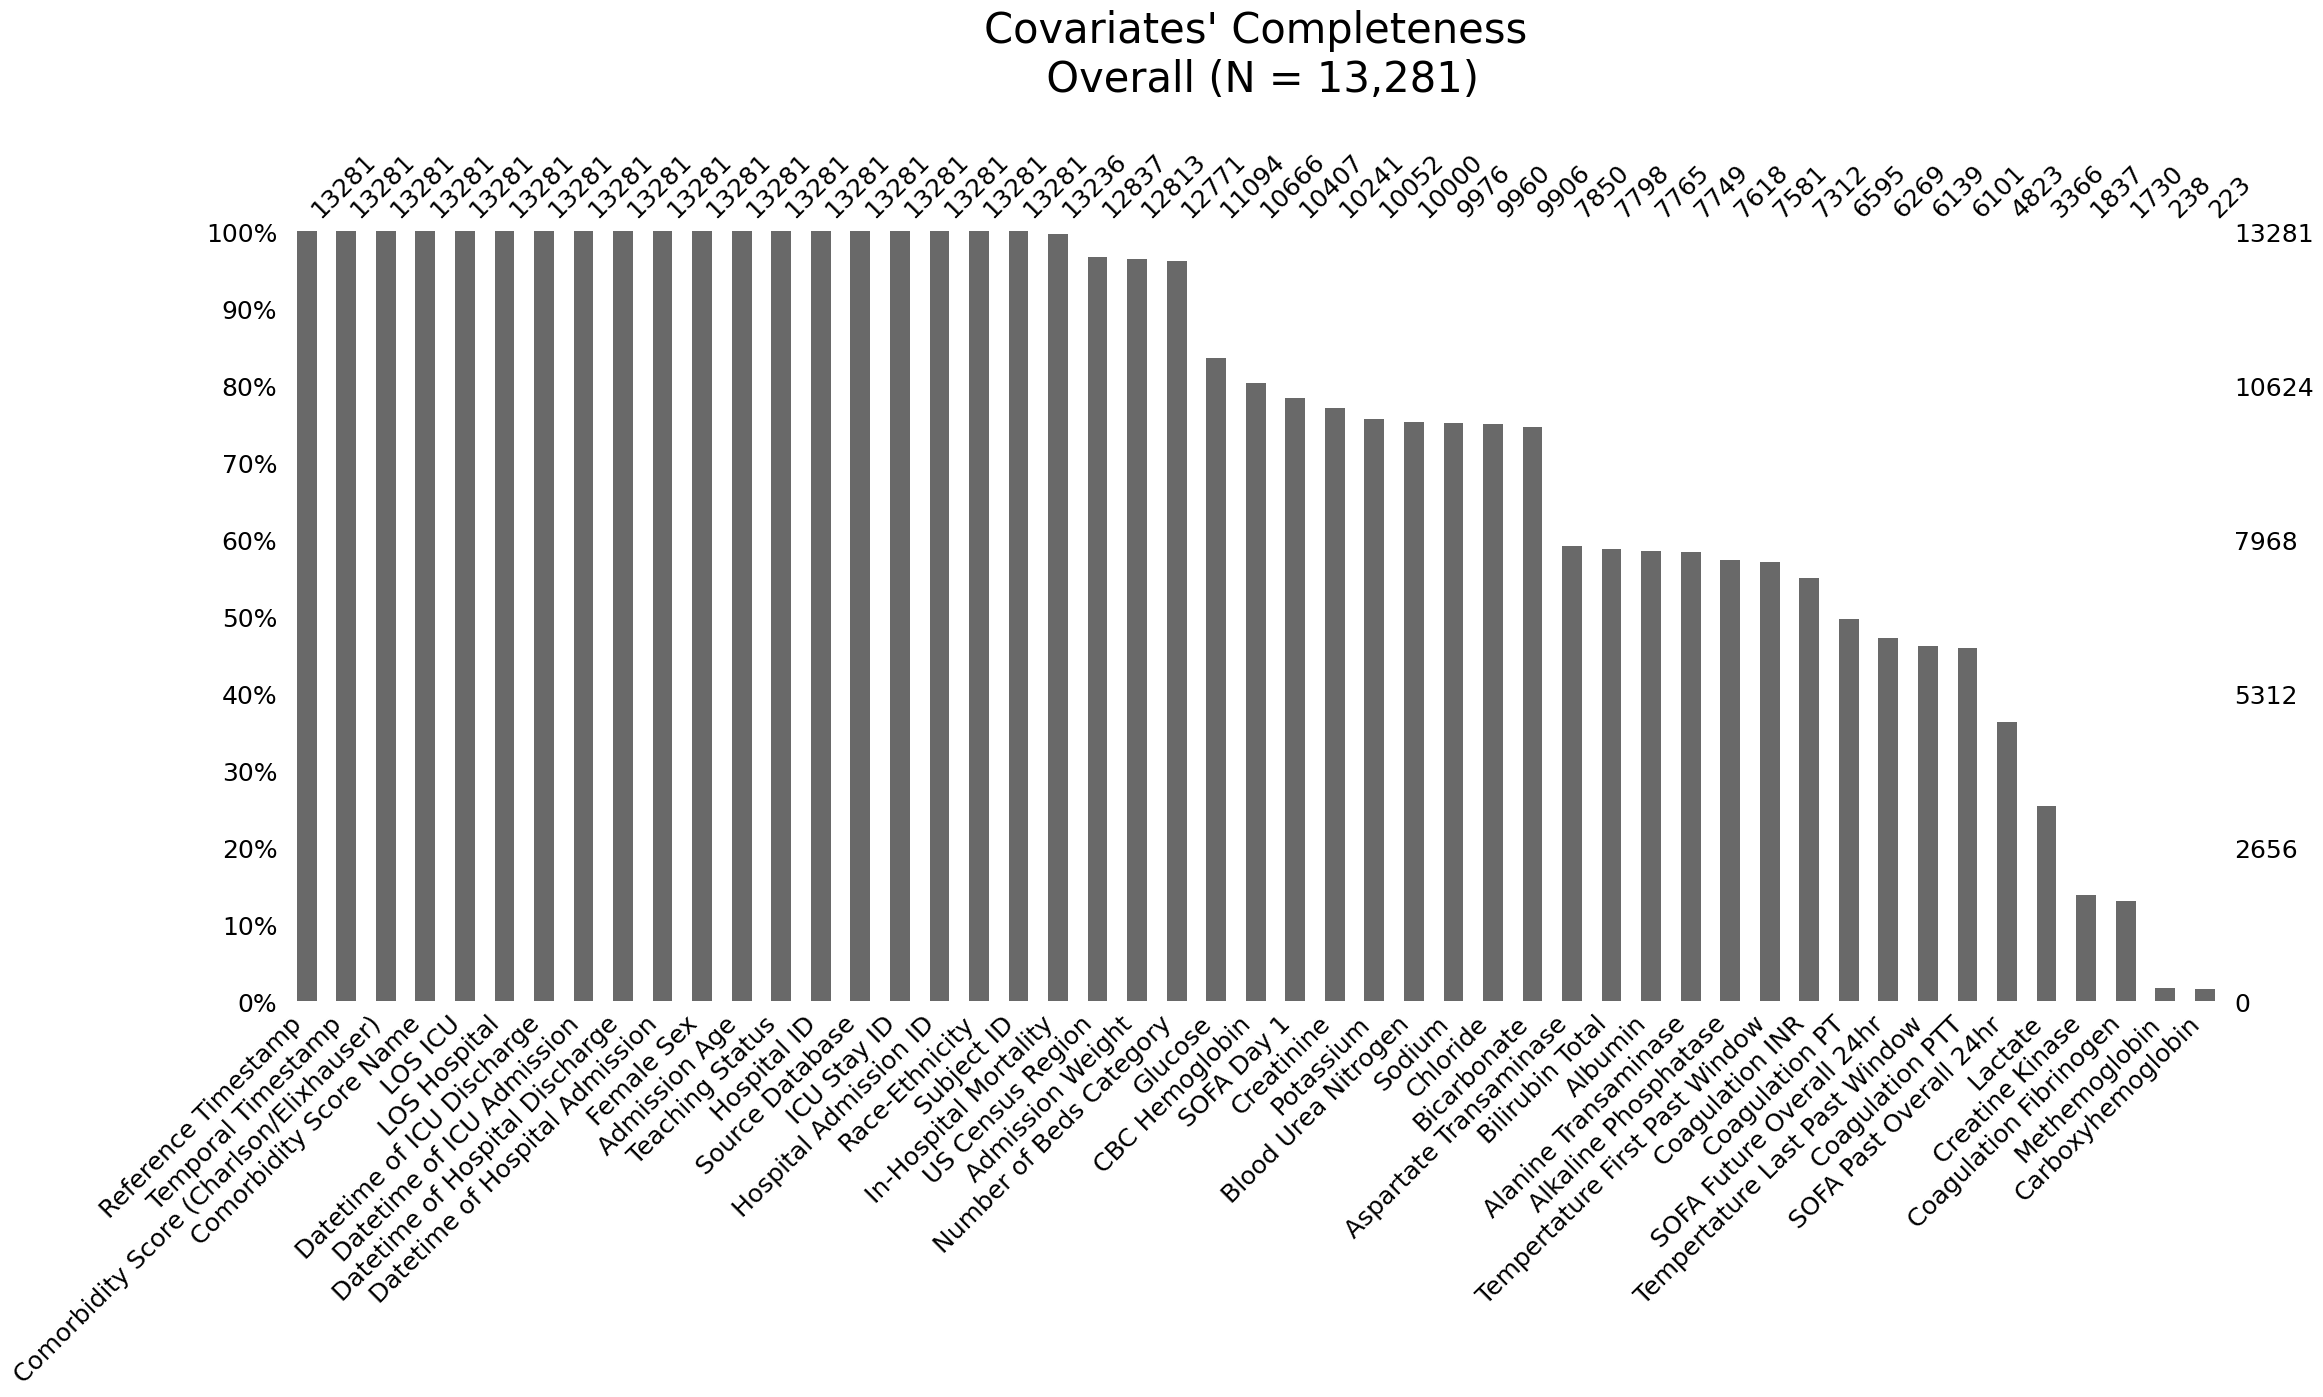

In [ ]:
plot_missingness(final_df)

## Stratify by Race and Ethnicity

### Asian

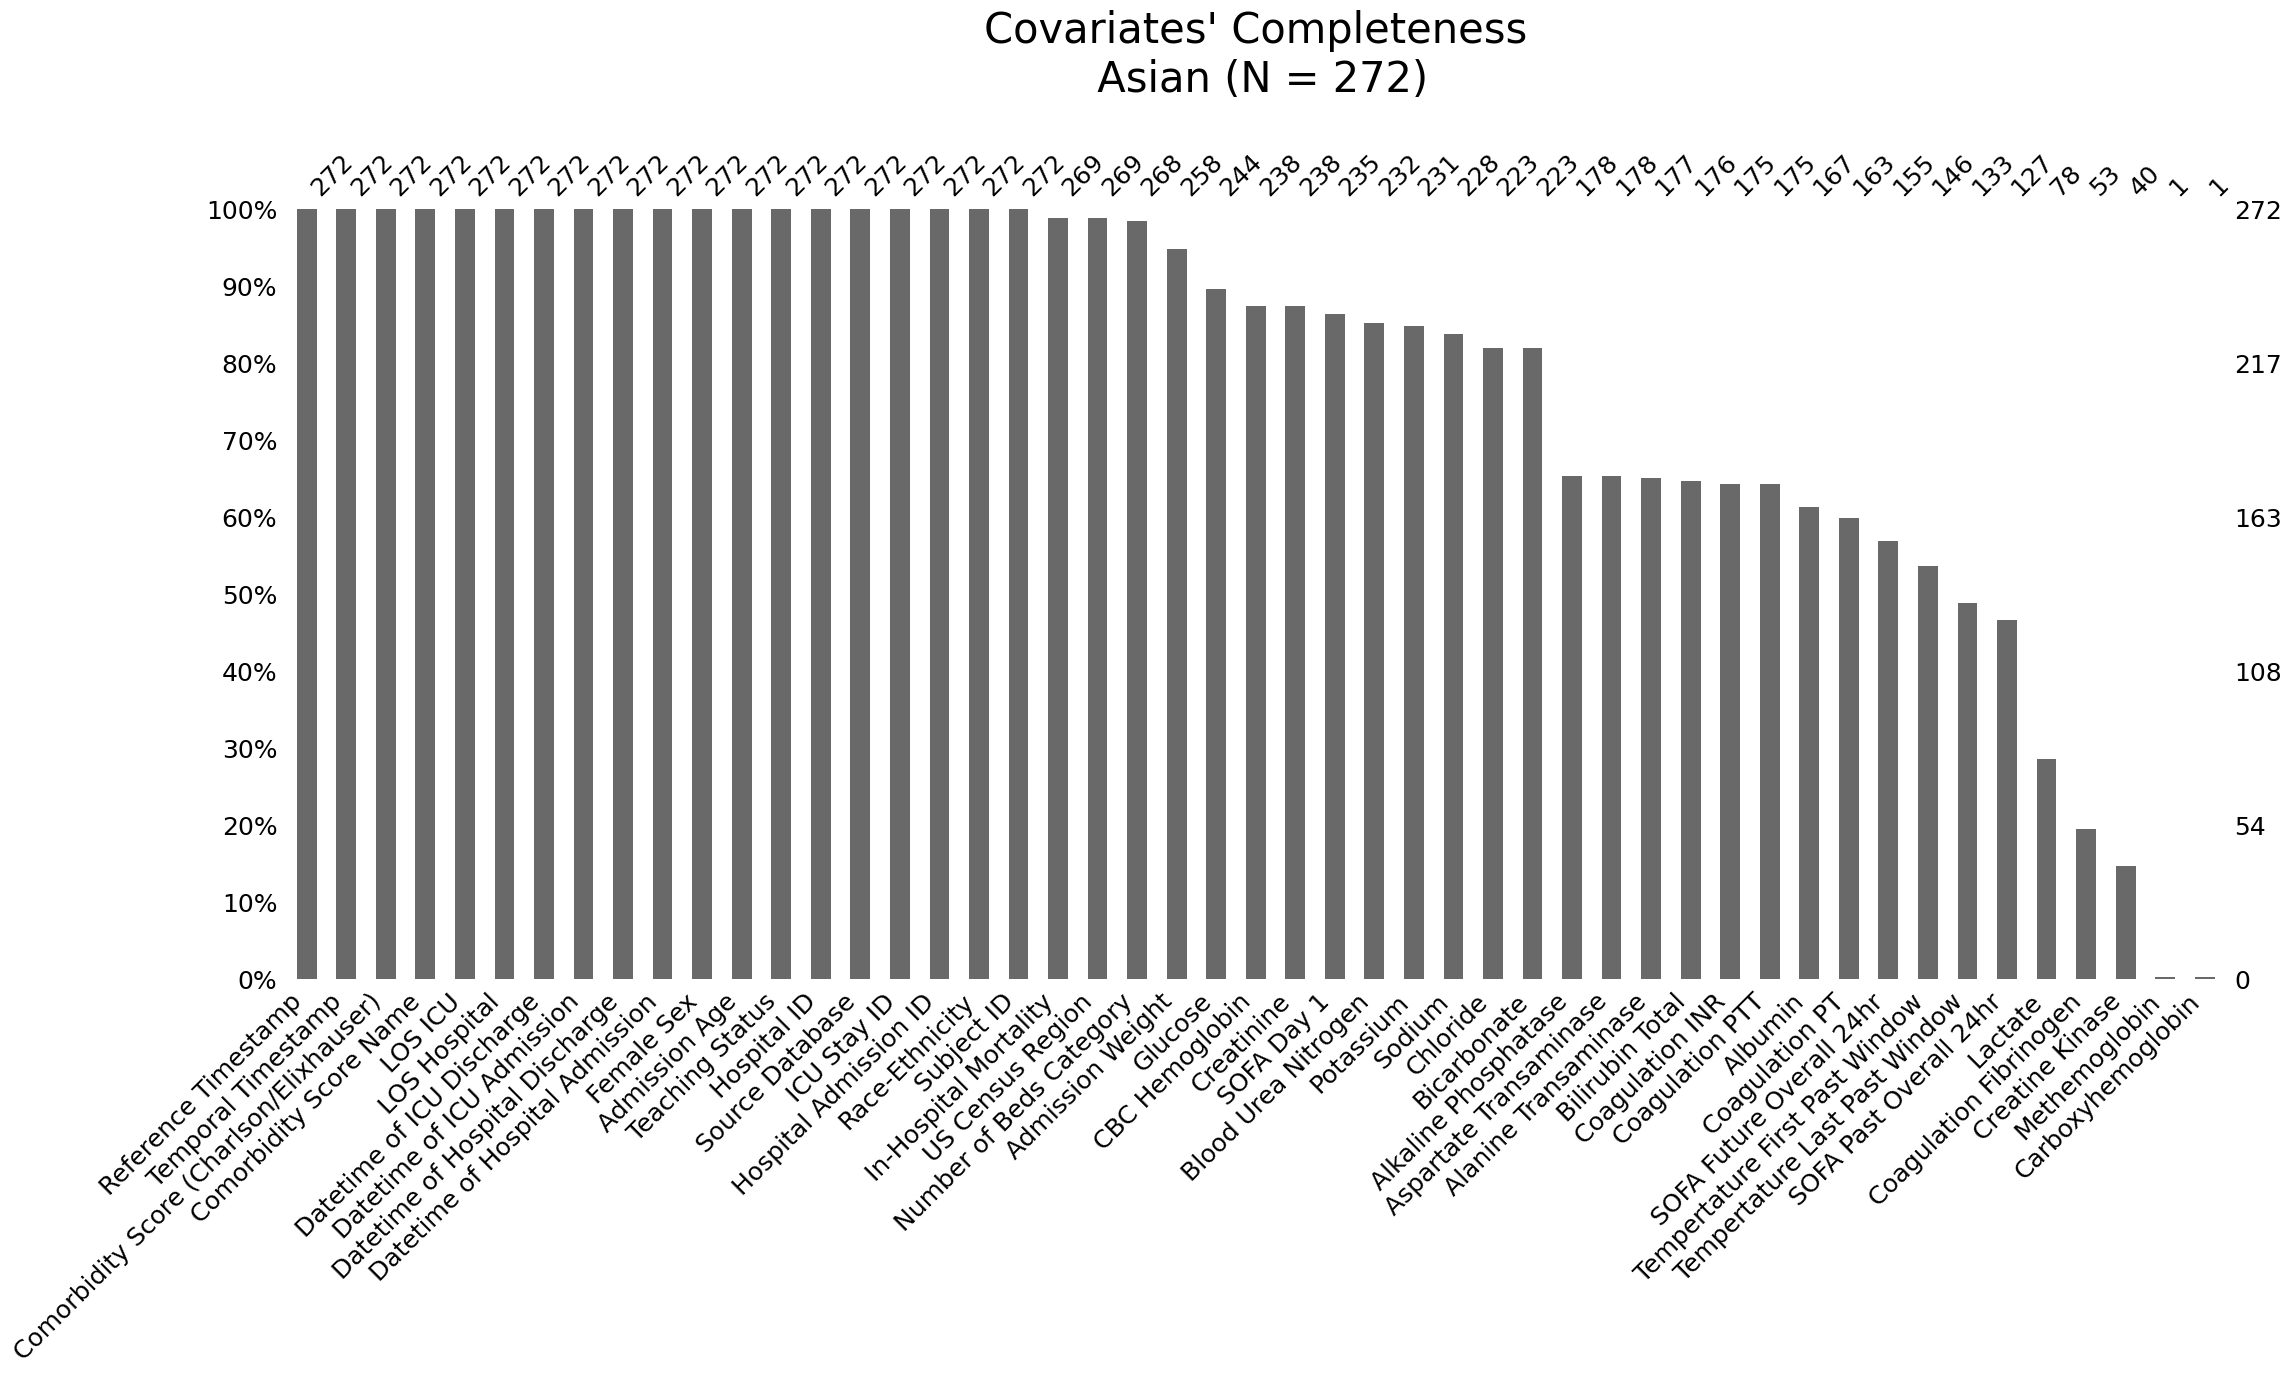

In [ ]:
plot_missingness(final_df.loc[final_df.race_ethnicity == "Asian"], "Asian")

### Black

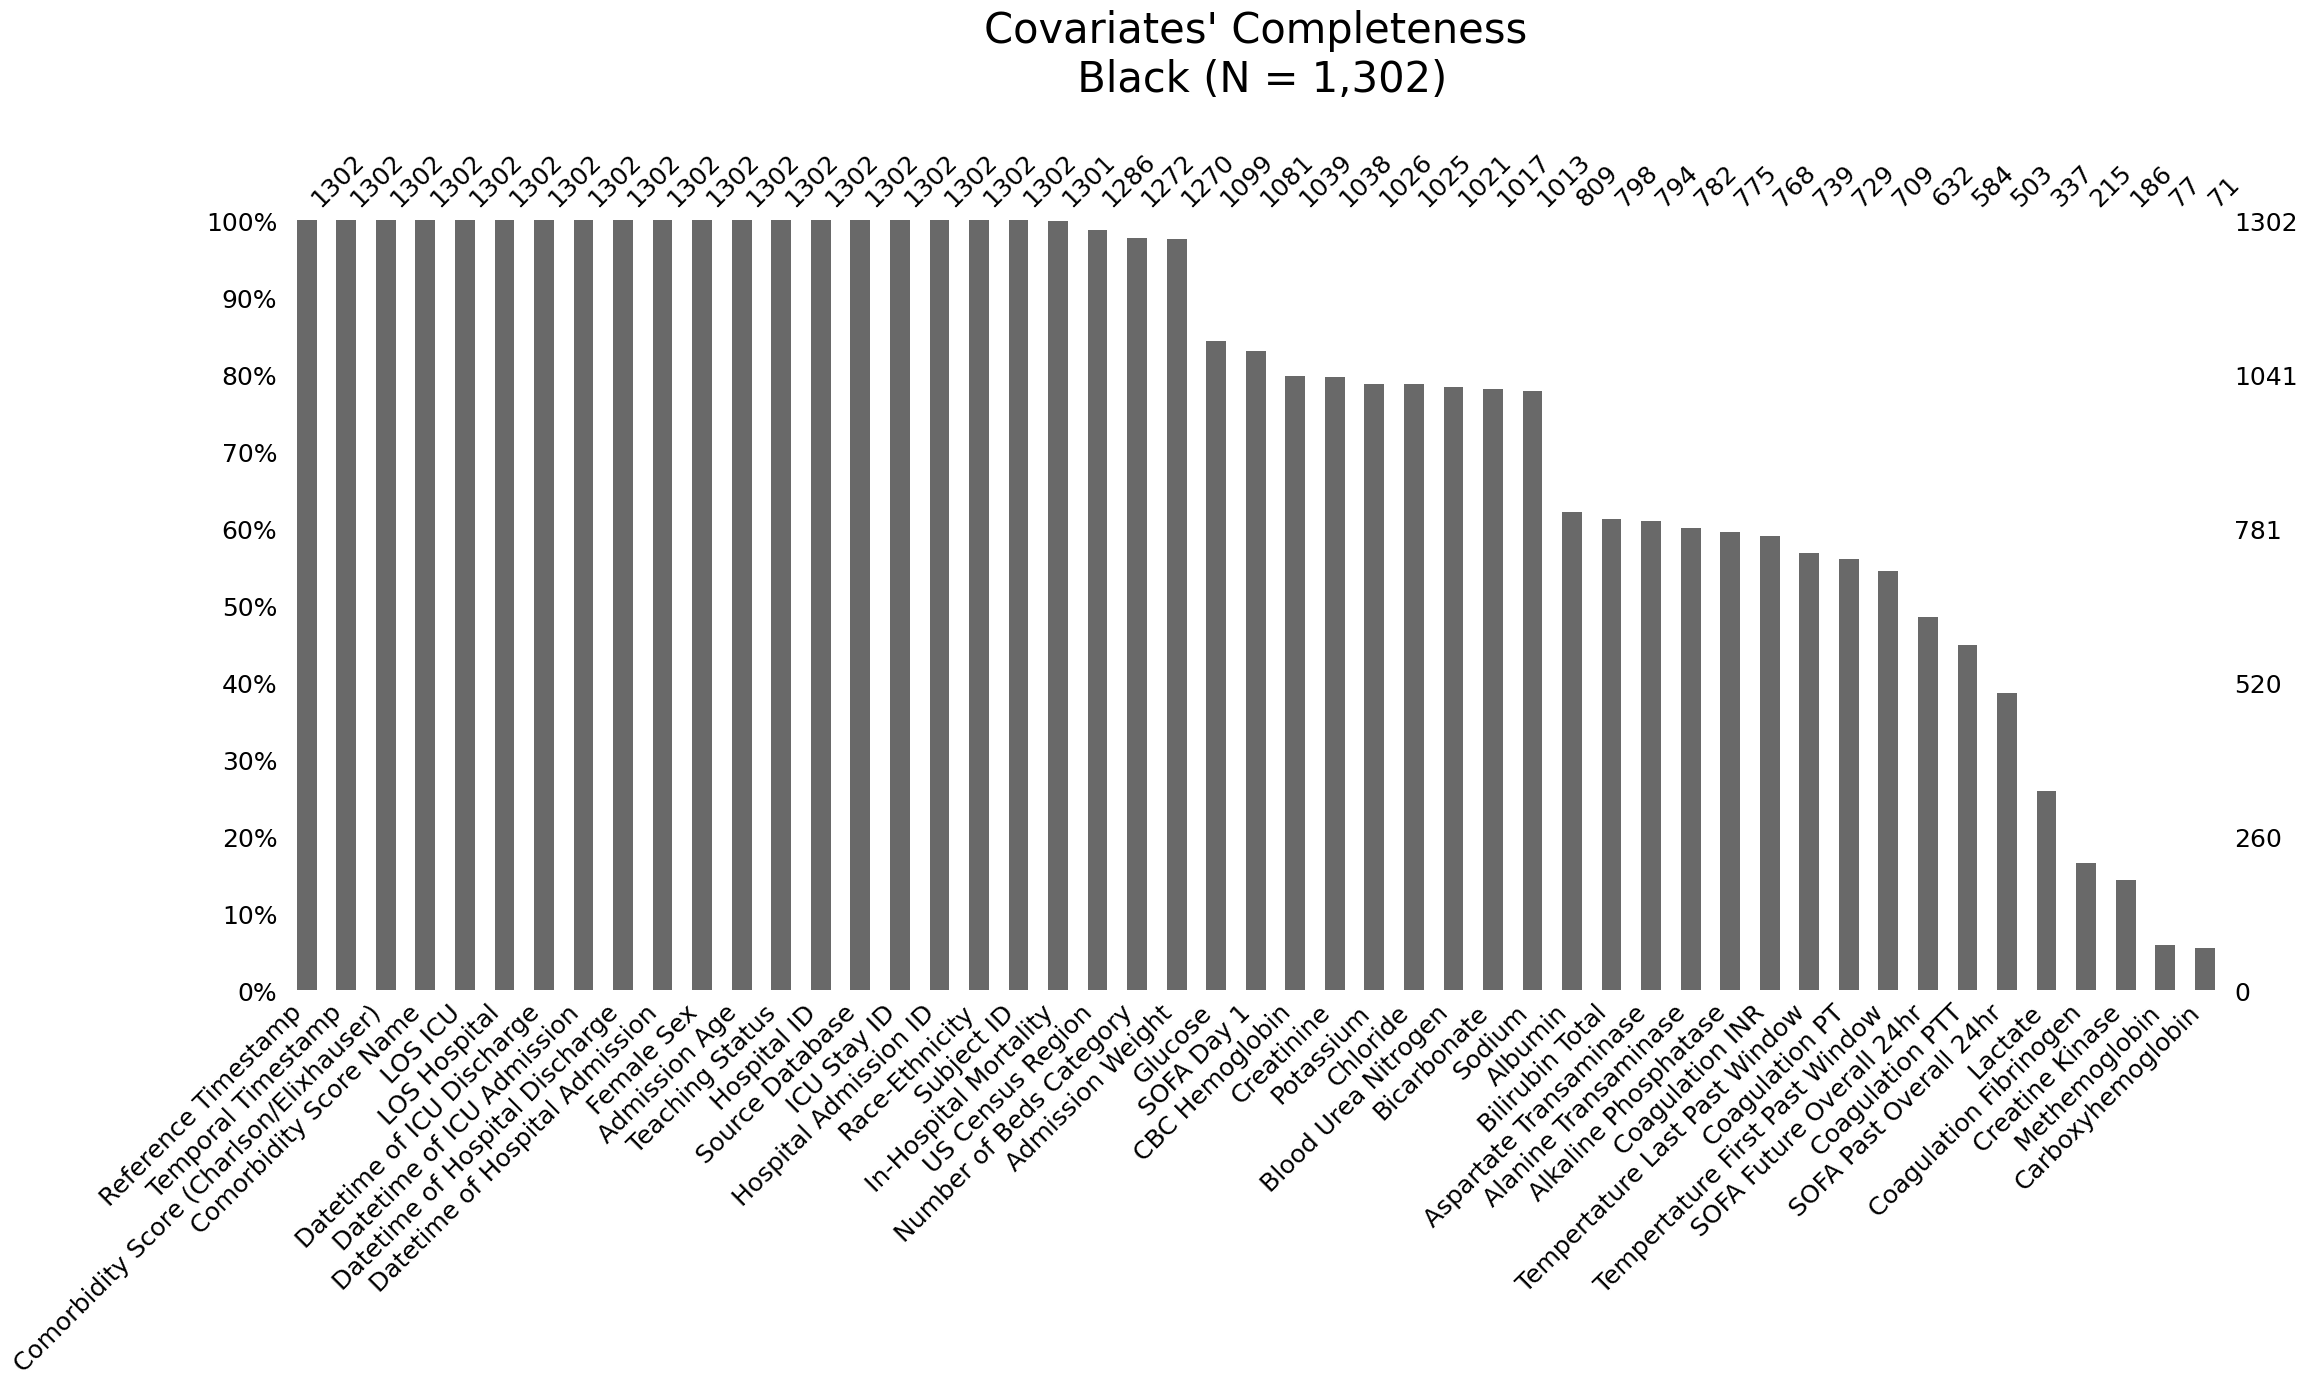

In [ ]:
plot_missingness(final_df.loc[final_df.race_ethnicity == "Black"], "Black")

### Hispanic OR Latino

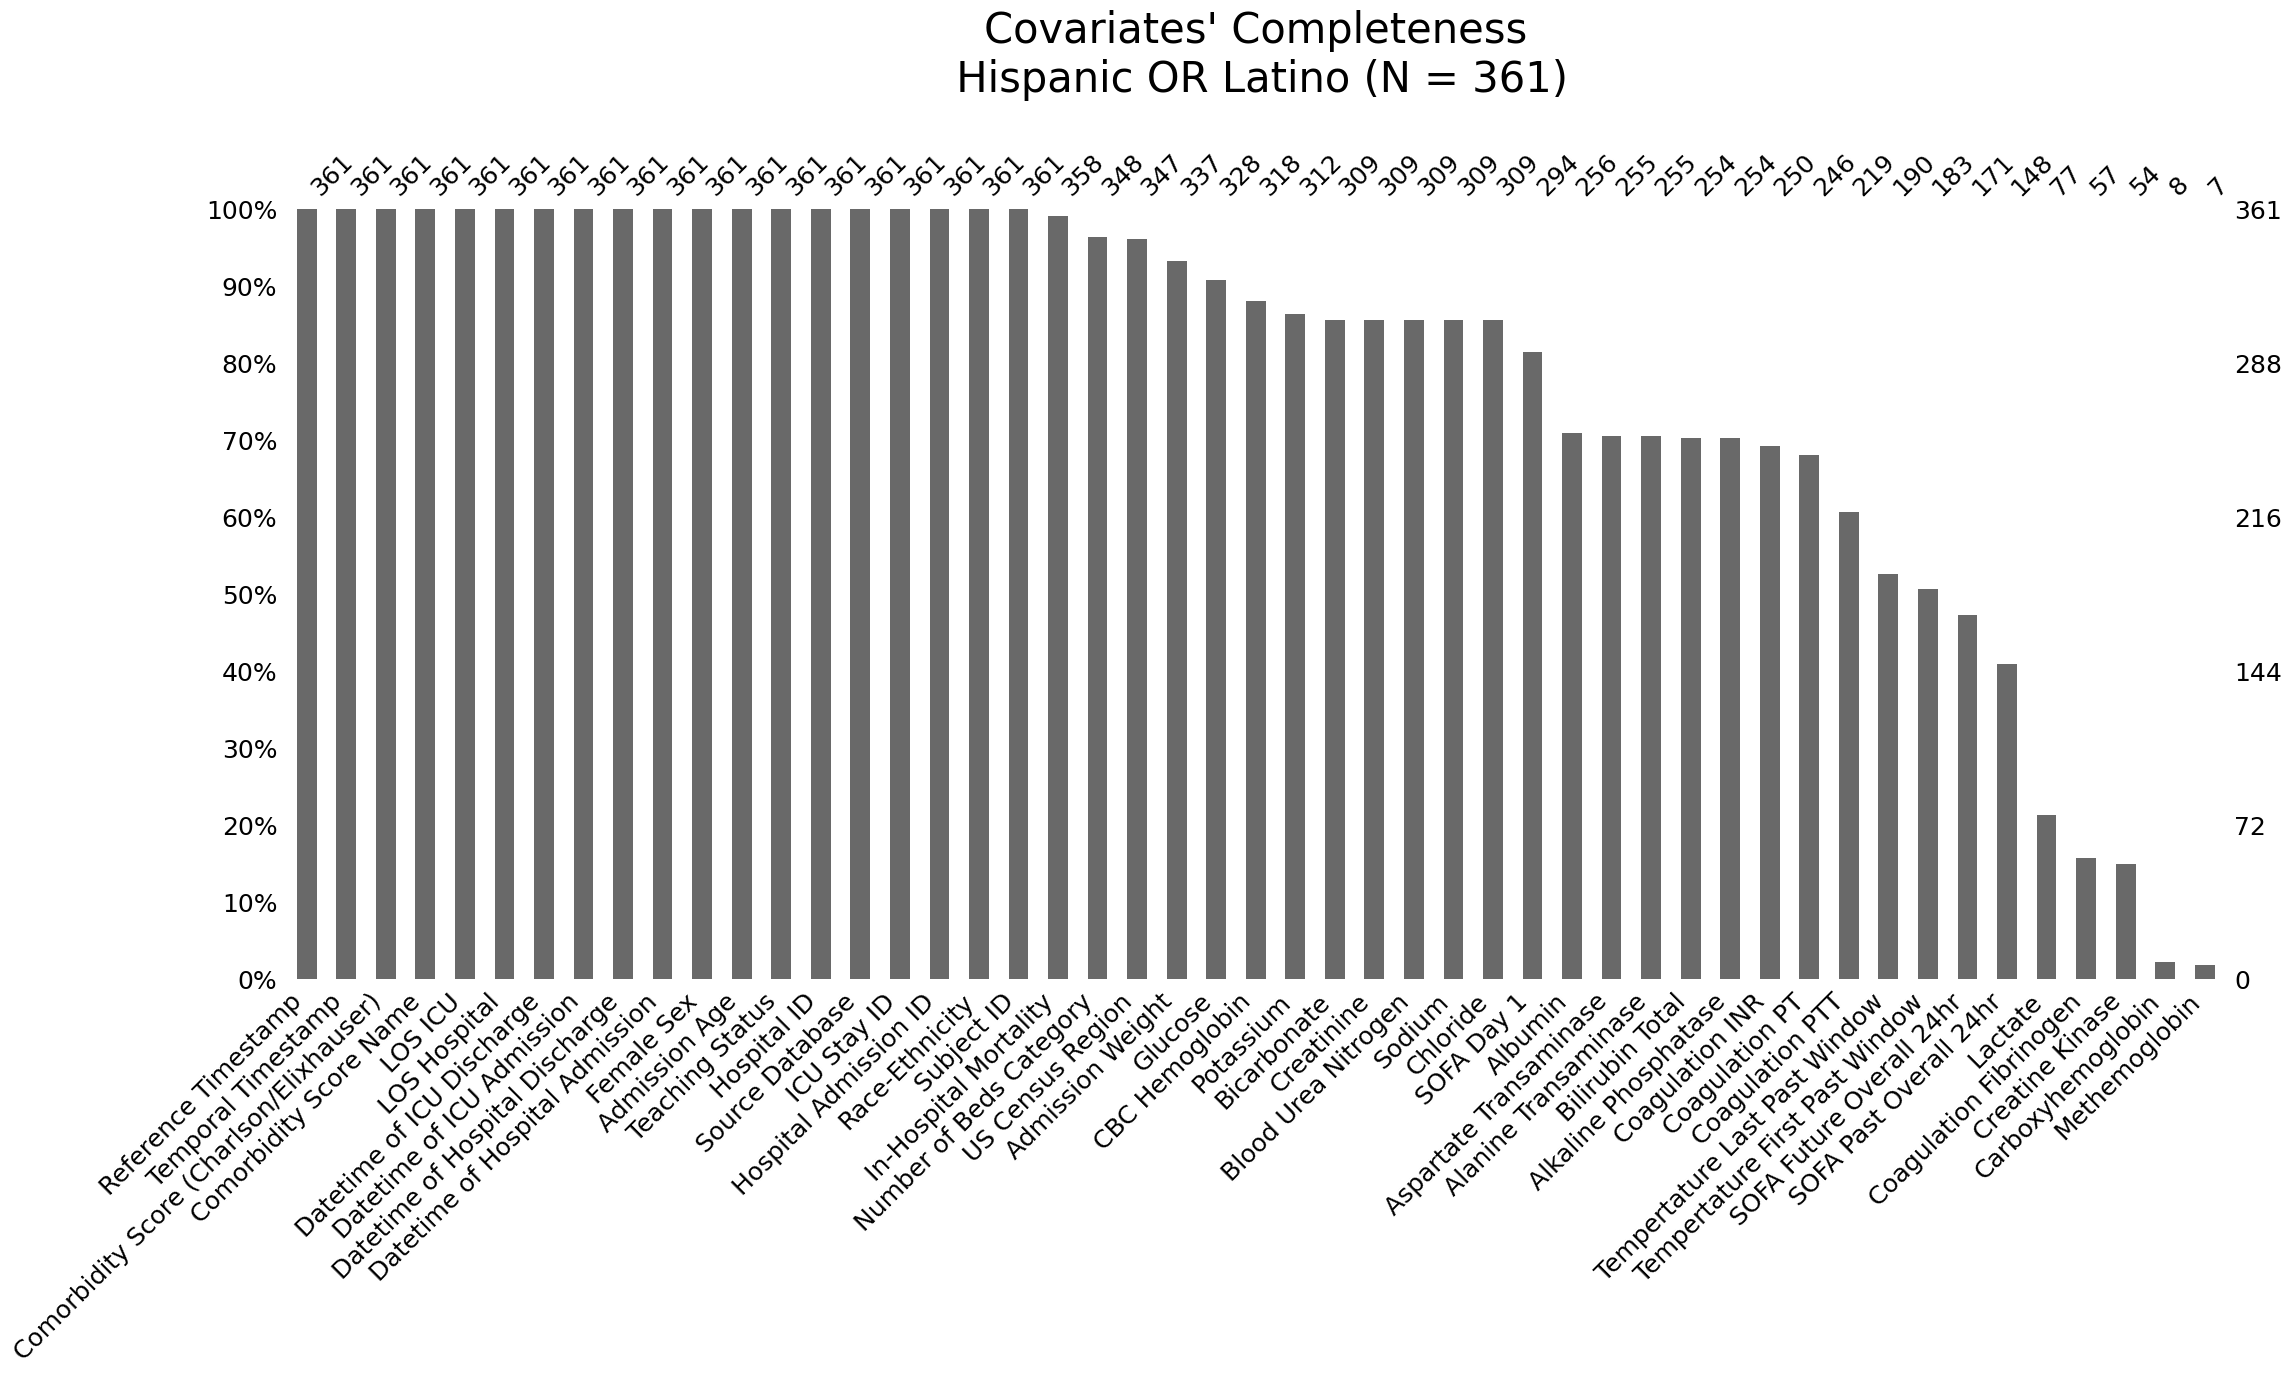

In [ ]:
plot_missingness(final_df.loc[final_df.race_ethnicity == "Hispanic OR Latino"], "Hispanic OR Latino")

### White

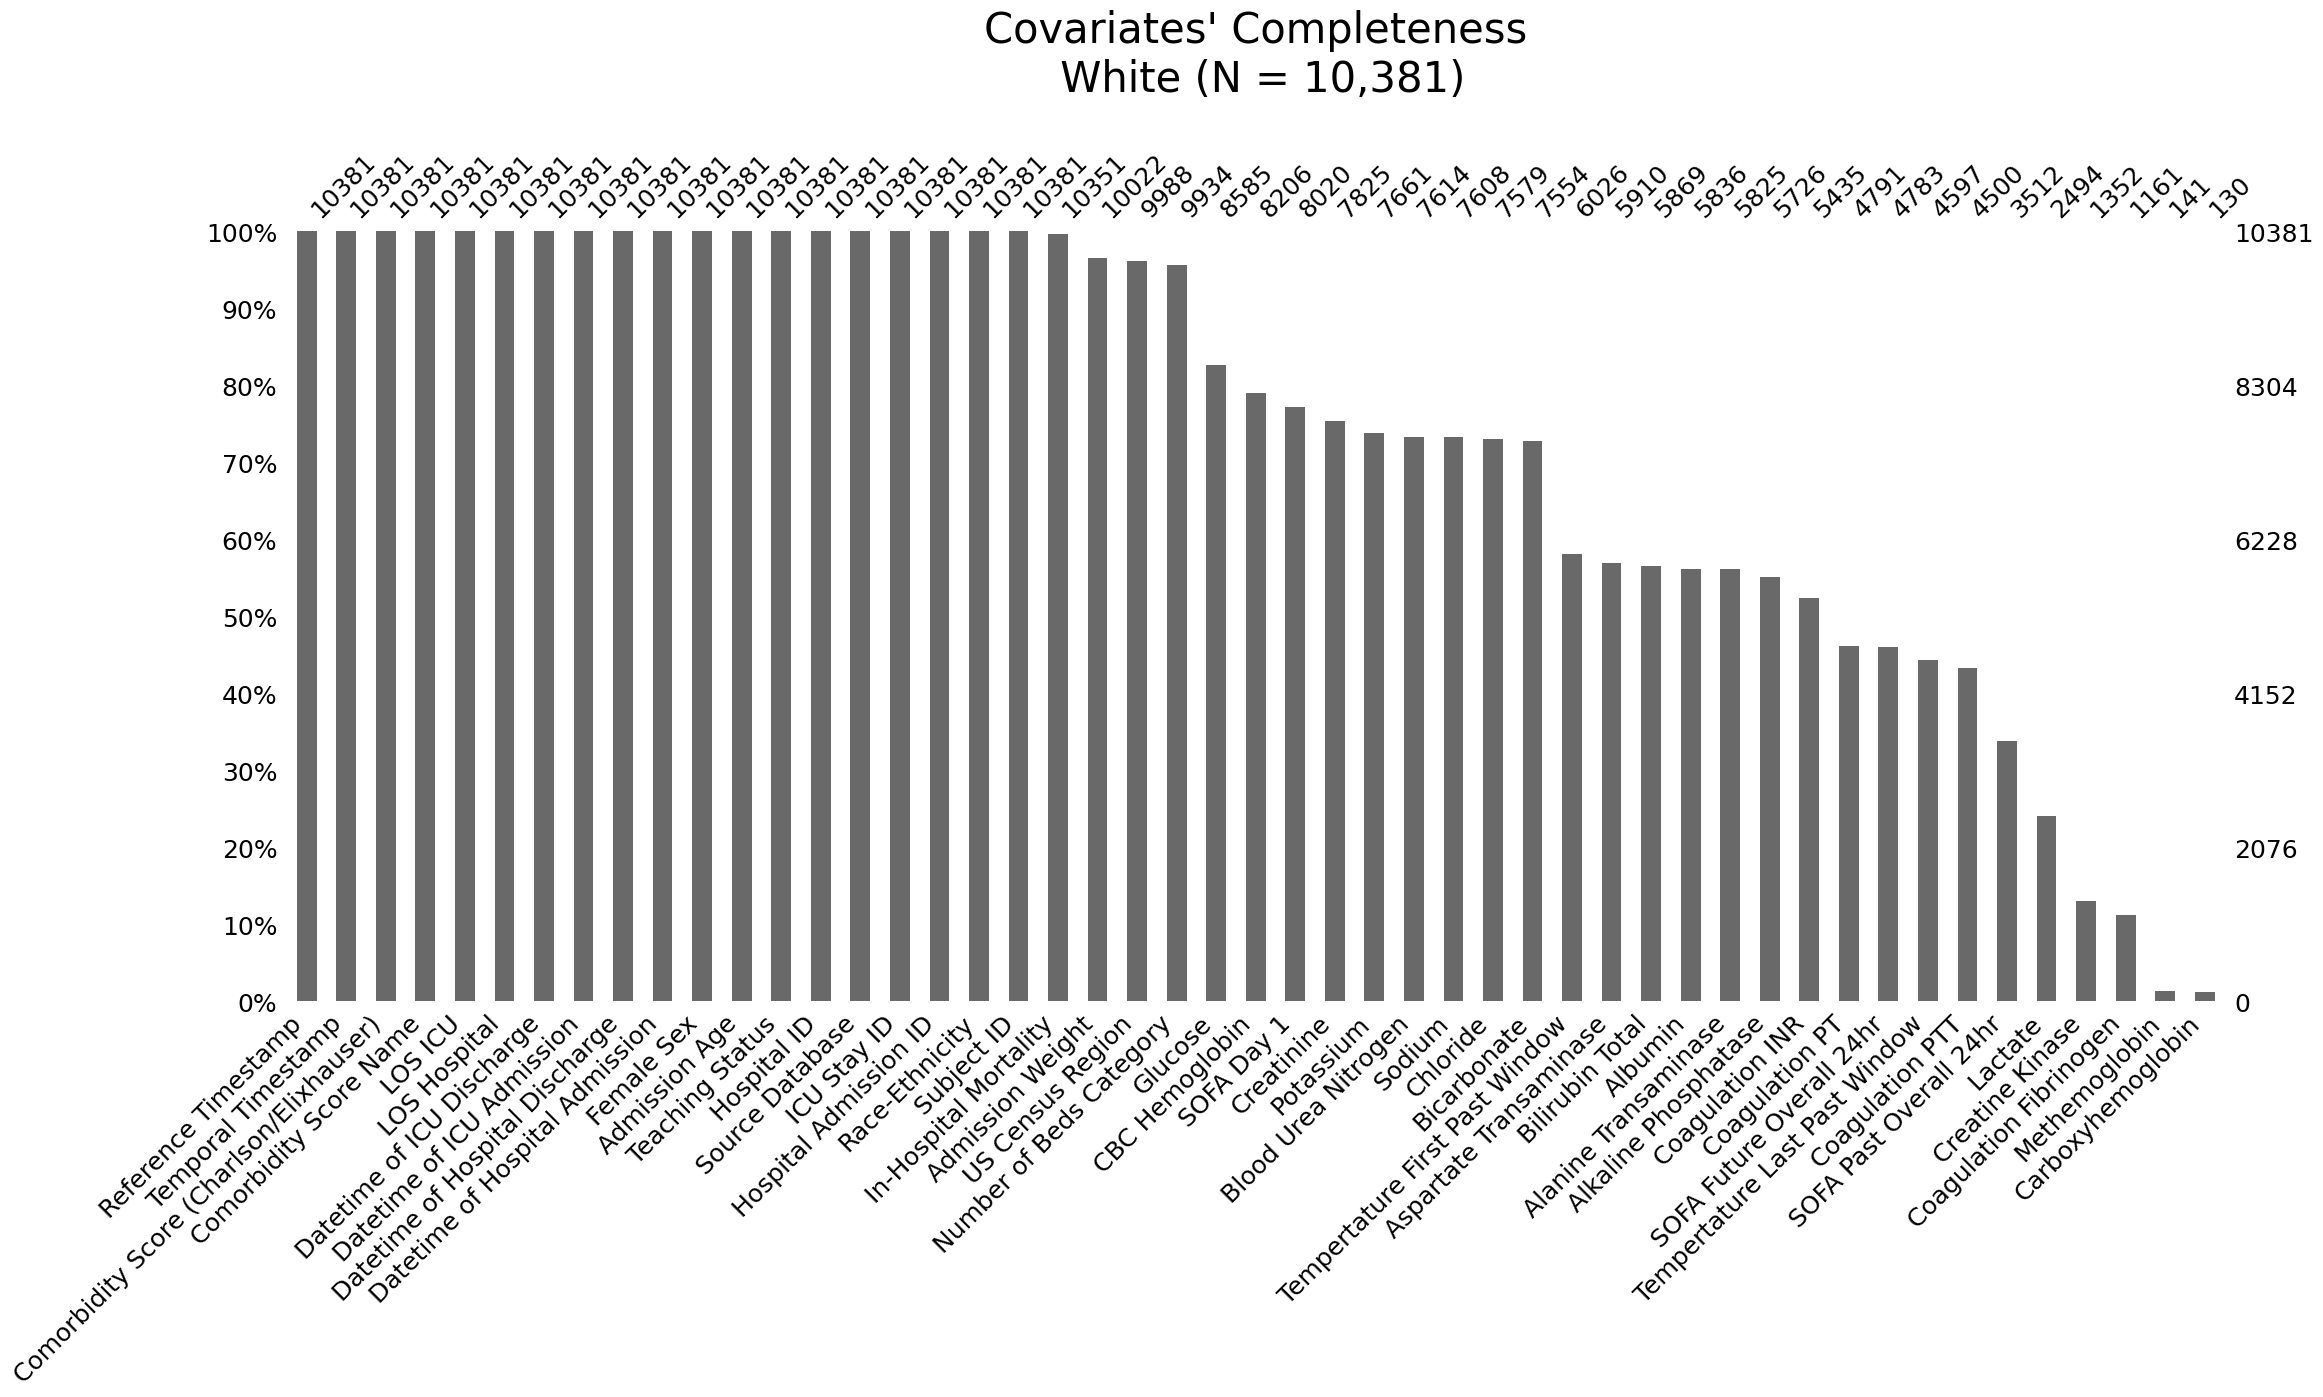

In [ ]:
plot_missingness(final_df.loc[final_df.race_ethnicity == "White"], "White")